In [1]:
import cv2
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import imageio
from skimage import img_as_float32
from natsort import natsorted
import torch

path_pairs = list(zip(
    natsorted(glob('../puzzle_corners_1024x768/images-1024x768/*.png')),
    natsorted(glob('../puzzle_corners_1024x768/masks-1024x768/*.png')),
))

imgs = np.array([img_as_float32(imageio.imread(ipath)) for ipath, _ in path_pairs])
msks = np.array([img_as_float32(imageio.imread(mpath)) for _, mpath in path_pairs])

# imgs_flat = imgs.reshape(-1,3) #might need to be 3 channels
# msks_flat = msks.reshape(-1)


In [2]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_test, msks_train, msks_test = train_test_split(
    imgs, msks, test_size=0.14, random_state=42)

In [3]:
imgs_train_flat =  torch.from_numpy(imgs_train.reshape(-1,3))
msks_train_flat =  torch.from_numpy(msks_train.reshape(-1))
imgs_test_flat = torch.from_numpy(imgs_test.reshape(-1,3))
msks_test_flat =  torch.from_numpy(msks_test.reshape(-1))

In [4]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=6)
# kf.get_n_splits(imgs_train)

In [5]:
from scipy.stats import multivariate_normal

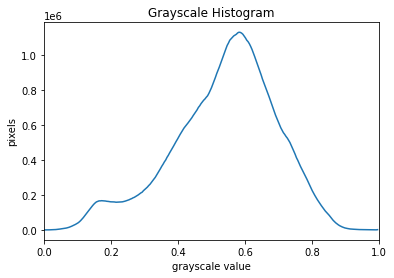

In [6]:
histogram, bin_edges = np.histogram(imgs_train, bins=256, range=(0, 1))
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

In [9]:
class GMM:
    def __init__(self, K, num_features):
        self.K = K
        self.lambd = np.ones(K)/K
        
        self.num_features = num_features
        self.mean = np.random.random((K, num_features))
        
        self.cov = np.random.random((K,num_features,num_features))

        self.prevent_singular = np.zeros((K,num_features,num_features))
        for k in range(K):
            self.prevent_singular[k] = 1e-6*np.eye(num_features)
            self.cov[k] *= self.cov[k].T
            self.cov[k] += 1e+3*np.eye(num_features)
            
        self.lambd = torch.from_numpy(self.lambd)
        self.mean = torch.from_numpy(self.mean)
        self.cov = torch.from_numpy(self.cov)
    
    def expectation(self, X):
        #make it self.R
        R = torch.zeros(len(X), self.K)
        for k in range(self.K):
            R[:, k] =  torch.mul(self.lambd[k],torch.from_numpy(multivariate_normal(mean = self.mean[k], cov=self.cov[k]).pdf(X)))

        log_likelihood =  torch.sum(torch.log(torch.sum(R, axis = 1)))

        R = torch.div(R, torch.sum(R, dim=1).unsqueeze(-1))
        
        return R, log_likelihood
    
    
    def maximisation(self, X, R):
        
        sum_r_ik = torch.sum(R, axis = 0)
        self.lambd = sum_r_ik/torch.sum(R)
        
        self.mean = torch.div(torch.matmul(R.T , X), sum_r_ik.reshape(-1,1))#lp
        
        for k in range(self.K):
            matmul = torch.matmul(torch.mul(R[:,k],(X - self.mean[k]).T), (X - self.mean[k]))
            self.cov[k] = torch.div(matmul ,sum_r_ik[k])
            
            #########################################################
            self.cov [torch.isnan(self.cov)] = 0
            self.cov = self.cov + self.prevent_singular
            ##--------------__#################-check
    
    def fit(self, X, max_iters, min_iters, converg_val):
        
        log_likelihood = 0 
        for i in range(max_iters):
            old_log_likelihood = log_likelihood
            R , log_likelihood = self.expectation(X)
            self.maximisation(X,R)
            
            change = np.abs(old_log_likelihood - log_likelihood)
            print(change)
            if change < converg_val and i > min_iters:
                break
                
    
    def predict(self, X):
        summ=0 
        for k in range(self.K):
            summ += self.lambd[k]*multivariate_normal(mean = self.mean[k], cov=self.cov[k]).pdf(X)
        return summ
        

In [10]:
gmm_back = GMM(4, 3)
gmm_back.fit(imgs_train_flat[msks_train_flat<0.5], 100,10, 1e-7)

RuntimeError: [enforce fail at CPUAllocator.cpp:68] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 9339428762118400 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
gmm_fore = GMM(4, 3)
gmm_fore.fit(imgs_train_flat[msks_train_flat>0.5], 100,10, 1e-7)

In [ ]:
fore = gmm_fore.predict(imgs_test_flat)
back = gmm_back.predict(imgs_test_flat)

In [ ]:
y = (0.4 * fore) / ((0.4 * fore) + ((1 - 0.4) * back))

In [ ]:
preds = (y>0.5).astype(np.float32)

In [ ]:
msks_test_flat[msks_test_flat>0.5] = 1.
msks_test_flat[msks_test_flat<0.5] = 0
np.unique(msks_test_flat)

In [ ]:
len(preds[preds == msks_test_flat])/len(preds)

In [ ]:
pred_ims = preds.reshape(msks_test.shape)

In [ ]:
plt.imshow(pred_ims[3], cmap = 'gray')

In [ ]:
plt.imshow(imgs_test[3])